## Lab 3

### Part 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile('drive/My Drive/UCI HAR Dataset (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/UCI HAR Dataset/')

KeyboardInterrupt: ignored

In [ ]:
!cd /drive/My\ Drive/UCI\ HAR\ Dataset/UCI\ HAR\ Dataset/

/bin/bash: line 0: cd: /drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/: No such file or directory


In [ ]:
!ls

drive  sample_data


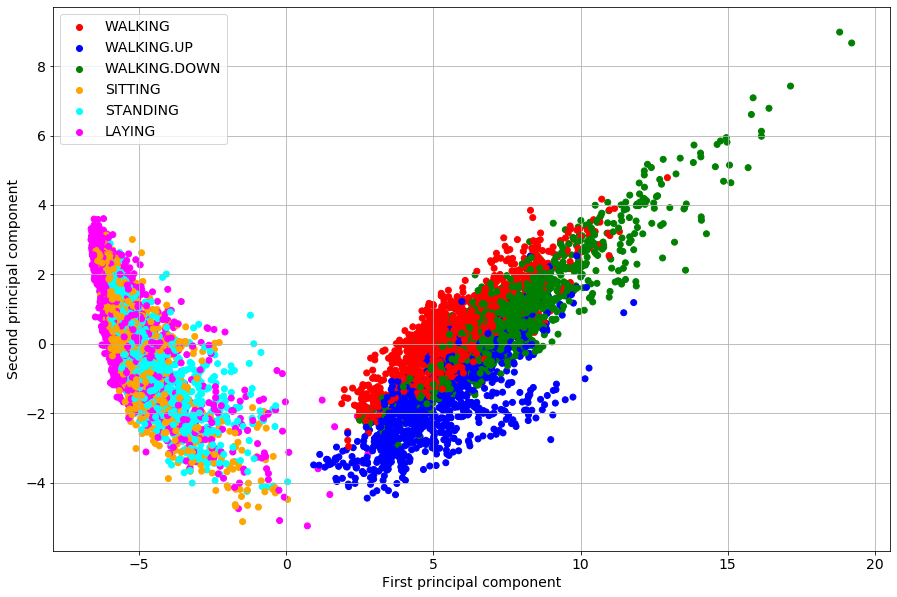

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("/content/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("/content/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "/content/drive/My Drive/UCI HAR Dataset/"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: /content/drive/My Drive/UCI HAR Dataset/UCI HAR Dataset/


In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=132)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

batch_size = 600
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, stratify=y_train, random_state=123, shuffle=True)
#X_dev = X_train[-int(0.2*len(X_train)):]
#y_dev = y_train[-int(0.2*len(X_train)):]
#X_train = X_train[:-int(0.2*len(X_train))]
#y_train = y_train[:-int(0.2*len(X_train))]
#X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train,
#                                                stratify = labels_train, random_state = 123)
train_batcher = DataLoader(list(zip(X_train, y_train[:, 0])), batch_size=batch_size)
dev_batcher = DataLoader(list(zip(X_dev, y_dev[:, 0])), batch_size=batch_size)
test_batcher = DataLoader(list(zip(X_test, y_test[:, 0])), batch_size=batch_size)

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, n_class, dropout=0.25):
        super(self.__class__, self).__init__()
        self.n_class = n_class
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=18, kernel_size=2, padding=1),
            #nn.BatchNorm1d(16),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=18, out_channels=36, kernel_size=2, padding=1),
            nn.BatchNorm1d(36),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        
        self.lstm = nn.LSTM(36, 36, bidirectional=True, batch_first=True, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(36, 6)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x1 = self.conv1(x.permute(0, 2, 1)).permute(0, 2, 1)
        _, (h, c) = self.lstm(x1)
        h = self.dropout(h).sum(0)

        return self.fc(h)

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_class, dropout=0.25):
        super(self.__class__, self).__init__()
        self.n_class = n_class
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=18, kernel_size=2, padding=1),
            #nn.BatchNorm1d(18),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=18, out_channels=36, kernel_size=2, padding=1),
            nn.BatchNorm1d(36),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=36, out_channels=72, kernel_size=2, padding=1),
            nn.BatchNorm1d(72),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=72, out_channels=144, kernel_size=2, padding=1),
            nn.BatchNorm1d(144),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # nn.Conv1d(in_channels=144, out_channels=288, kernel_size=2, padding=1),
            # nn.BatchNorm1d(288),
            # nn.ReLU(),
            # #nn.Dropout(dropout),
            # nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.lin1 = nn.Linear(8*144, 6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x.permute(0, 2, 1)).permute(0, 2, 1).reshape(x.size(0), -1)
        #print(x.size())
        x = self.dropout(x)
        x = self.lin1(x)
        return x

In [ ]:
model = CNN(6, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=20)

In [ ]:
n_epoch = 400
print_every = 5
early_stop_n = 4

In [ ]:
history = []
for ep in range(n_epoch):
    tr_acc = 0
    tr_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_batcher):
        x, y = x.to(device), y.to(device).long()
        pred = model(x)
        #print(pred.size(), y.size())
        loss = criterion(pred, y)
        tr_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        model.zero_grad()

        tr_acc += (pred.argmax(-1) == y).sum().item()

        if i % print_every == 0 and i > 0:
            print(f'\t Iter {i}. loss: {tr_loss / (i+1):.5f}, acc: {tr_acc / (i+1) / batch_size :.5f}')
        #break
    tr_acc /= len(train_batcher)*batch_size
    tr_loss /= len(train_batcher)
    print(f'Epoch {ep}. tr loss: {tr_loss:.5f}, tr acc: {tr_acc:.5f}')
    
    test_acc = 0
    test_loss = 0
    
    #if True:
    with torch.no_grad():
        model.eval()
        for i, (x, y) in enumerate(dev_batcher):
            x, y = x.to(device), y.to(device).long()
            pred = model(x)
            
            loss = criterion(pred, y)
            test_loss += loss.item()

            test_acc += (pred.argmax(-1) == y).sum().item()

            #if i % print_every == 0 and i > 0:
            #    print(f'\t Iter {i}. loss: {test_loss / (i+1)}, acc: {test_acc / (i+1)}')
            #break
    test_acc /= len(dev_batcher)*batch_size
    test_loss /= len(dev_batcher)
    #scheduler.step(test_loss)
    history.append(test_loss)
    print(f'dev loss: {test_loss:.5f}, dev acc: {test_acc:.5f}')

    if ep < early_stop_n or not np.all(np.diff(history[-early_stop_n:]) > 0):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'acc': test_acc
        }, '/content/drive/My Drive/UCI HAR Dataset/check.pt')

	 Iter 5. loss: 0.00877, acc: 0.99750
Epoch 0. tr loss: 0.00834, tr acc: 0.91683
dev loss: 0.04891, dev acc: 0.75542
	 Iter 5. loss: 0.00869, acc: 0.99639
Epoch 1. tr loss: 0.00809, tr acc: 0.91567
dev loss: 0.04696, dev acc: 0.75667
	 Iter 5. loss: 0.01093, acc: 0.99556
Epoch 2. tr loss: 0.01098, tr acc: 0.91483
dev loss: 0.04172, dev acc: 0.75542
	 Iter 5. loss: 0.00994, acc: 0.99667
Epoch 3. tr loss: 0.00919, tr acc: 0.91600
dev loss: 0.04442, dev acc: 0.75583
	 Iter 5. loss: 0.01255, acc: 0.99528
Epoch 4. tr loss: 0.01218, tr acc: 0.91450
dev loss: 0.06472, dev acc: 0.75708
	 Iter 5. loss: 0.01039, acc: 0.99583
Epoch 5. tr loss: 0.00991, tr acc: 0.91467
dev loss: 0.05595, dev acc: 0.75542
	 Iter 5. loss: 0.01379, acc: 0.99444
Epoch 6. tr loss: 0.01217, tr acc: 0.91400
dev loss: 0.05541, dev acc: 0.75750
	 Iter 5. loss: 0.01282, acc: 0.99500
Epoch 7. tr loss: 0.01113, tr acc: 0.91517
dev loss: 0.04634, dev acc: 0.75792
	 Iter 5. loss: 0.01211, acc: 0.99583
Epoch 8. tr loss: 0.00971,

In [ ]:
test_acc = 0
test_loss = 0
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_batcher):
        x, y = x.to(device), y.to(device).long()
        pred = model(x)
        
        loss = criterion(pred, y)
        test_loss += loss.item()

        test_acc += (pred.argmax(-1) == y).sum().item()

test_acc /= len(test_batcher)*batch_size
test_loss /= len(test_batcher)
print(f'test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')

test loss: 0.93841, test acc: 0.91067


In [ ]:
model = CNNLSTM(6, dropout=0.).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=20)

In [ ]:
n_epoch = 200
print_every = 5
early_stop_n = 4

In [ ]:
history = []
for ep in range(n_epoch):
    tr_acc = 0
    tr_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_batcher):
        x, y = x.to(device), y.to(device).long()
        pred = model(x)

        loss = criterion(pred, y)
        tr_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        model.zero_grad()

        tr_acc += (pred.argmax(-1) == y).sum().item()

        if i % print_every == 0 and i > 0:
            print(f'\t Iter {i}. loss: {tr_loss / (i+1):.5f}, acc: {tr_acc / (i+1) / batch_size :.5f}')
        #break
    tr_acc /= len(train_batcher)*batch_size
    tr_loss /= len(train_batcher)
    print(f'Epoch {ep}. tr loss: {tr_loss:.5f}, tr acc: {tr_acc:.5f}')
    
    test_acc = 0
    test_loss = 0
    
    #if True:
    with torch.no_grad():
        model.eval()
        for i, (x, y) in enumerate(dev_batcher):
            x, y = x.to(device), y.to(device).long()
            pred = model(x)
            
            loss = criterion(pred, y)
            test_loss += loss.item()

            test_acc += (pred.argmax(-1) == y).sum().item()

            #if i % print_every == 0 and i > 0:
            #    print(f'\t Iter {i}. loss: {test_loss / (i+1)}, acc: {test_acc / (i+1)}')
            #break
    test_acc /= len(dev_batcher)*batch_size
    test_loss /= len(dev_batcher)
    #scheduler.step(test_loss)
    history.append(test_loss)
    print(f'dev loss: {test_loss:.5f}, dev acc: {test_acc:.5f}')

    if ep < early_stop_n or not np.all(np.diff(history[-early_stop_n:]) > 0):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'acc': test_acc
        }, '/content/drive/My Drive/UCI HAR Dataset/check.pt')

	 Iter 5. loss: 0.01521, acc: 0.99361
Epoch 0. tr loss: 0.01568, tr acc: 0.91183
dev loss: 0.05668, dev acc: 0.75042
	 Iter 5. loss: 0.01627, acc: 0.99389
Epoch 1. tr loss: 0.01578, tr acc: 0.91267
dev loss: 0.05143, dev acc: 0.75083
	 Iter 5. loss: 0.01738, acc: 0.99111
Epoch 2. tr loss: 0.01718, tr acc: 0.91033
dev loss: 0.04752, dev acc: 0.75333
	 Iter 5. loss: 0.01777, acc: 0.99444
Epoch 3. tr loss: 0.01696, tr acc: 0.91283
dev loss: 0.06808, dev acc: 0.75083
	 Iter 5. loss: 0.01602, acc: 0.99361
Epoch 4. tr loss: 0.01775, tr acc: 0.91150
dev loss: 0.07049, dev acc: 0.75208
	 Iter 5. loss: 0.02323, acc: 0.99139
Epoch 5. tr loss: 0.02110, tr acc: 0.91083
dev loss: 0.08050, dev acc: 0.74917
	 Iter 5. loss: 0.01860, acc: 0.99083
Epoch 6. tr loss: 0.01890, tr acc: 0.90983
dev loss: 0.09642, dev acc: 0.74917
	 Iter 5. loss: 0.02799, acc: 0.98972
Epoch 7. tr loss: 0.02602, tr acc: 0.90817
dev loss: 0.07045, dev acc: 0.74875
	 Iter 5. loss: 0.02175, acc: 0.98944
Epoch 8. tr loss: 0.02110,

In [ ]:
test_acc = 0
test_loss = 0
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_batcher):
        x, y = x.to(device), y.to(device).long()
        pred = model(x)
        
        loss = criterion(pred, y)
        test_loss += loss.item()

        test_acc += (pred.argmax(-1) == y).sum().item()

test_acc /= len(test_batcher)*batch_size
test_loss /= len(test_batcher)
print(f'test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')

test loss: 0.58976, test acc: 0.89633


Я попробовал CNN и CNN+LSTM. Первый способ дал 91 на тесте, второй 89,6. Обучал каждую модель 400 эпох. В итоге у меня получилось.

### Часть 4. Optional. Dogs classification.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$96% - 2 points
* $>=$85% - 1.5 points
* $>=$70% - 0.75 points